## Apprentissage par transfert :

### Définition :
L'apprentissage par transfert est une technique d'apprentissage automatique dans laquelle un réseau qui a été formé pour effectuer une tâche spécifique est réutilisé comme point de départ pour une autre tâche similaire.

L'apprentissage par transfert est l'amélioration de l'apprentissage d'une nouvelle tâche par le transfert d'une connaissance d'une tâche connexe qui a déjà été apprise.

### Quand utiliser le transfer learning :
- Lorsque le réseau de base et le réseau qu'on souhaite entrainer exécutent des tâches similaires.
- Lorsque la dataset du réseau à entrainer est petite par rapport à celle du réseau de base.

### Le processus du transfer learning :

![](https://drive.google.com/uc?id=1KQoIsmxzUvS69DGWskoXPj1GxtXWIzII)

Les premières couches CNN sont utilisées pour extraire des caractéristiques de haut niveau.  
Les dernières couches sont utilisées pour effectuer une classification sur une tâche spécifique.  
==> Donc, on copie les premières couches(modèle de base) puis on ajoute des couches personnalisées dans la sortie du réseau.

### Les stratégies du transfer learning :
1 -  
On fixe les poids des premières couches du réseau.  
On entraine seulement les nouvelles couches ajoutées (avec des poids aléatoires).  
2 -  
On initialise le réseau CNN avec les poids pre-entrainés.  
On re-entraine le réseau avec un learning rate très petit pour s'assurer qu'il y n'y aura pas un grand changement des poids.



### Les avantages du transfer learning :
- Rapidité dans l'entrainement du réseau.  
- Vous n'avez pas besoin de repartir à zéro.  
- Vous pouvez utiliser une petite dataset et obtenir des résultats très meilleurs.


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from keras.models import model_from_json


In [ ]:
def read_image(file_path) :
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)

def prepare_data(images) :
  m = len(images)
  print(m)
  X = np.zeros((m, 256, 256, 3), dtype = np.uint8)
  y = np.zeros((1, m), dtype = np.uint8)
  for i, image_file in enumerate(images) :
    print(i, image_file)
    X[i,:] = read_image(image_file)
    if 'rock' in image_file :
      y[0,i] = 0
    elif 'paper' in image_file :
      y[0,i] = 1
    elif 'scissor' in image_file :
      y[0,i] = 2
  return X,y

def convert_to_one_hot(Y,C) :
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y

In [ ]:
read_image('/content/gdrive/My Drive/datasets/rps-dataset/train/0paper.jpg').shape

(256, 256, 3)

In [ ]:
CLASSES = 3
CHANNELS = 3
HEIGHT = 256
WIDTH = 256

train_path="/content/gdrive/My Drive/datasets/rps-dataset/train/"
test_path ="/content/gdrive/My Drive/datasets/rps-dataset/test/"

train_images = [train_path+i for i in os.listdir(train_path)]
test_images  = [test_path+i for i in os.listdir(test_path)]

train_set_x, train_set_y = prepare_data(train_images)
test_set_x , test_set_y  = prepare_data(test_images)

X_train = train_set_x/255
X_test  = test_set_x/255

Y_train = convert_to_one_hot(train_set_y, CLASSES).T
Y_test  = convert_to_one_hot(test_set_y, CLASSES).T

1710
0 /content/gdrive/My Drive/datasets/rps-dataset/train/159rock.jpg
1 /content/gdrive/My Drive/datasets/rps-dataset/train/172rock.jpg
2 /content/gdrive/My Drive/datasets/rps-dataset/train/489rock.jpg
3 /content/gdrive/My Drive/datasets/rps-dataset/train/78rock.jpg
4 /content/gdrive/My Drive/datasets/rps-dataset/train/72rock.jpg
5 /content/gdrive/My Drive/datasets/rps-dataset/train/544rock.jpg
6 /content/gdrive/My Drive/datasets/rps-dataset/train/151rock.jpg
7 /content/gdrive/My Drive/datasets/rps-dataset/train/512rock.jpg
8 /content/gdrive/My Drive/datasets/rps-dataset/train/332rock.jpg
9 /content/gdrive/My Drive/datasets/rps-dataset/train/391rock.jpg
10 /content/gdrive/My Drive/datasets/rps-dataset/train/103rock.jpg
11 /content/gdrive/My Drive/datasets/rps-dataset/train/246rock.jpg
12 /content/gdrive/My Drive/datasets/rps-dataset/train/112rock.jpg
13 /content/gdrive/My Drive/datasets/rps-dataset/train/73rock.jpg
14 /content/gdrive/My Drive/datasets/rps-dataset/train/386rock.jpg
15 

In [ ]:
Y_train[45]

array([0., 1., 0.])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1710, 256, 256, 3)
(426, 256, 256, 3)
(1710, 3)
(426, 3)


In [ ]:
X_test[0].shape

(256, 256, 3)

### Charger le moèle de base Inception Resnetv2

In [ ]:
basemodel = InceptionResNetV2( weights = 'imagenet',
                               include_top = False,
                               input_tensor = Input(shape=(256,256,3))
                             )

219062272/219055592 [==============================] - 1s 0us/step


### Afficher le modèle summary

In [ ]:
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

### Freeze the basemodel weights , so these weights won't change during training

In [ ]:
basemodel.trainable = False

### Add classification head to the model

In [ ]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = 'global_average_pooling')(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation='relu', name = 'dense_1')(headmodel)
# Drop out to avoid overfitting
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu', name = 'dense_2')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(CLASSES, activation='softmax',name = 'dense_3')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

## Compile and train deep learning model

### Compile the model

In [ ]:
model.compile( loss='categorical_crossentropy',
               optimizer = SGD(lr=0.01, momentum=0.9),
               metrics =  ['accuracy']
             )

### Save the best model

In [ ]:
checkpointer = ModelCheckpoint( filepath="/content/gdrive/My Drive/datasets/rps-dataset/trans_learn_best_model.hdf5",
                                verbose = 1,
                                save_best_only = True
                               )

### Train The model

In [ ]:
model.fit(X_train, Y_train, epochs=20, batch_size=16)

Epoch 1/20
107/107 [==============================] - 55s 127ms/step - loss: 0.4314 - accuracy: 0.8263
Epoch 2/20
107/107 [==============================] - 13s 120ms/step - loss: 0.0699 - accuracy: 0.9730
Epoch 3/20
107/107 [==============================] - 13s 121ms/step - loss: 0.0366 - accuracy: 0.9937
Epoch 4/20
107/107 [==============================] - 13s 122ms/step - loss: 0.0333 - accuracy: 0.9874
Epoch 5/20
107/107 [==============================] - 13s 122ms/step - loss: 0.0207 - accuracy: 0.9939
Epoch 6/20
107/107 [==============================] - 13s 123ms/step - loss: 0.0214 - accuracy: 0.9951
Epoch 7/20
107/107 [==============================] - 13s 123ms/step - loss: 0.0223 - accuracy: 0.9933
Epoch 8/20
107/107 [==============================] - 13s 123ms/step - loss: 0.0118 - accuracy: 0.9955
Epoch 9/20
107/107 [==============================] - 13s 124ms/step - loss: 0.0094 - accuracy: 0.9965
Epoch 10/20
107/107 [==============================] - 13s 124ms/step - l

### Evaluation

In [ ]:
preds = model.evaluate(X_test, Y_test)
print("loss = ", preds[0])
print("test accuracy = ", preds[1])

14/14 [==============================] - 8s 261ms/step - loss: 0.0231 - accuracy: 0.9930
loss =  0.02307463064789772
test accuracy =  0.9929577708244324


### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Prediction

'Paper'

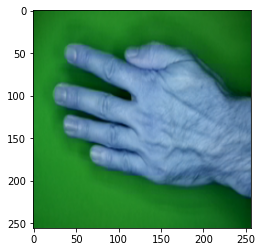

In [ ]:
def predict_rps(img) :
  labels = {0: 'Rock', 1: 'Paper', 2: 'Scissor'}
  preds = model.predict(np.expand_dims(img, axis=0))
  preds = np.argmax(preds)
  return labels[preds]

plt.imshow(X_test[55])
predict_rps(X_test[55])

### Serialize model to JSON and Serialize weights to HDF5

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/datasets/rps-dataset/model_tl.json",'w') as json_file :
  json_file.write(model_json)
model.save_weights("/content/gdrive/My Drive/datasets/rps-dataset/model_tl.h5")

### Load JSON and create model

In [ ]:
json_file = open("/content/gdrive/My Drive/datasets/rps-dataset/model_tl.json",'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/datasets/rps-dataset/model_tl.h5")

In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
preds2 = loaded_model.evaluate(X_test, Y_test)
print("loss = ", preds2[0])
print("test accuracy = ", preds2[1])

14/14 [==============================] - 7s 205ms/step - loss: 0.0175 - accuracy: 0.9945
loss =  0.02307463064789772
test accuracy =  0.9929577708244324
